**Выполнила:** Подгорная Виолетта, *М80-304Б, №10 по списку*

# Лабораторная работа №2

## Алгоритмы классификации

### Расчет варианта

*Расчет дополнительного алгоритма*

In [1]:
GROUP_NUM = 10

if GROUP_NUM % 2:
    print("Дополнительно Random Forest")
else:
    print("Дополнительно Support Vector Machine")

Дополнительно Support Vector Machine


### Импорт данных

*Импортируем подготовленные данные из первой лабораторной работы*

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt 

In [3]:
X_PATH = "data/x_class.csv"
Y_PATH = "data/y_class.csv"

In [4]:
X = pd.read_csv(X_PATH)
Y = pd.read_csv(Y_PATH)

### Подготовка данных

*Сплит на тренировочную/валидационную выборку, нормализация, приведение к numpy формату*

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

In [6]:
scale_features_std = MinMaxScaler()

X = scale_features_std.fit_transform(X) 

print("Тип данных после преобразования:", type(X))

Тип данных после преобразования: <class 'numpy.ndarray'>


In [7]:
Y = Y.to_numpy().ravel()

print("Тип данных после преобразования:", type(Y))

Тип данных после преобразования: <class 'numpy.ndarray'>


In [8]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=42, stratify=Y)

print("Из", len(X), "записей", len(X_train), "тренровочных и", len(X_test), "тестовых")

Из 303 записей 242 тренровочных и 61 тестовых


### Классификация

*Обучение самодельных и slearn моделей и сравнение метрик*

#### Инструменты 

In [9]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import metrics
from sklearn.metrics import accuracy_score as accuracy
from sklearn.metrics import classification_report
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns

In [10]:
# взято из интернета

# построение confusion матрицы
def conf_matrix(model, x, y):
    y_pred = model.predict(x)
    cnf_matrix = metrics.confusion_matrix(y, y_pred)
    p = sns.heatmap(pd.DataFrame(cnf_matrix), annot=True, cmap="YlGnBu" ,fmt='g')
    plt.title('Confusion matrix', y=1.1)
    plt.ylabel('Actual label')
    plt.xlabel('Predicted label')
    
# построениe вывода по классификации с оновными метриками
def metric_report(model, x, y):
    y_pred = model.predict(x)
    print(classification_report(y, y_pred))

In [11]:
# этот гридсерч позволяет настраивать параметры у моих моделей аналогично 
# sklearn GridSearchCV
class OwnGridSearchCV:
    def  __init__(self, model, param_grid, cv=5, random_state=42, metric=accuracy):
        self.model = model
        self.grid = param_grid
        self.cv = cv
        self.kf = KFold(n_splits=cv, shuffle=True, random_state=random_state)
        self.best_score_ = 0
        self.best_params_ = None
        self.metric = metric
        
    def fit(self, X, Y):
        counter = np.zeros(len(self.grid)).astype(np.int16)
        keys = tuple(self.grid.keys())
        now_params = dict(self.grid)
        num = 1
        for key in keys:
            num *= len(self.grid[key])
        for _ in tqdm(range(num)):
            for i in range(len(keys)):
                now_params[keys[i]] = self.grid[keys[i]][counter[i]]
            score = 0.0
            for train_idx, test_idx in self.kf.split(X):
                X_train, X_test = X[train_idx], X[test_idx]
                Y_train, Y_test = Y[train_idx], Y[test_idx]
                model = self.model(**now_params)
                model.fit(X_train, Y_train)
                score += model.score(X_test, Y_test, metric=self.metric)
            score /= self.cv
            if score > self.best_score_:
                self.best_score_ = score
                self.best_params_ = dict(now_params)
            k = -1
            while True:
                if k < -len(counter):
                    return self
                counter[k] += 1
                if counter[k] < len(self.grid[keys[k]]):
                    break
                else:
                    counter[k] = 0
                    k -= 1

#### Логистическая регрессия

In [12]:
from sklearn.linear_model import LogisticRegression

Реализация алгоритма:

In [13]:
# эта реализация сигмоиды со stackowerflow лучше справляется с большими х
def sigmoid(x):
    return np.exp(-np.logaddexp(0, -x))

def logit_grad(x, y, w):
    koeff = (y * sigmoid(-y*x.dot(w)))
    koeff = koeff.reshape((koeff.shape[0], 1))
    return -(koeff * x).sum(axis = 0)

# логистическая регрессия для бинарной классификации
class OwnLogisticRegression:
    def __init__(self, speed = 1, l2_reg = False, C=0.5, eps=0.001, maxsteps=2000):
        self.w = None
        self.speed = speed
        self.maxsteps = maxsteps
        self.eps = eps
        if l2_reg:
            self.l2 = lambda w: w / C
        else:
            self.l2 = lambda w: 0.0
    # решатель - градиентный спуск    
    def gradien_descent_search(self, X, Y):
        w0 = np.zeros(X.shape[1])
        w = np.random.random(X.shape[1])
        k = 1
        while np.linalg.norm(w - w0) > self.eps and k <= self.maxsteps:
            w0 = w
            temp = self.speed * ((1 / k)**0.5) 
            w = w - temp*(logit_grad(X, Y, w) + self.l2(w))
            k += 1
        self.w = w
        return self.w
    
    def fit(self, X_train, Y_train):
        Y = np.array(Y_train)
        Y[Y_train == 0] = -1
        x0 = np.ones((X_train.shape[0], 1))
        X = np.hstack((x0, X_train))
        self.gradien_descent_search(X, Y)
        return self
    
    def predict(self, X_val, border = 0):
        x0 = np.ones((X_val.shape[0], 1))
        X = np.hstack((x0, X_val))
        Xw = X.dot(self.w)
        Y_pred = np.zeros(Xw.shape).astype(np.int8)
        Y_pred[Xw >= border] = 1
        return Y_pred
    
    def score(self, X_val, Y_val, metric=accuracy):
        return metric(Y_val, self.predict(X_val))

*slkearn:*

In [14]:
param_grid = {'C':np.arange(0.1, 3, 0.04)}
log_cv = GridSearchCV(LogisticRegression(),param_grid,cv=5)
log_cv.fit(X_train, Y_train)

print("Best Score:" + str(log_cv.best_score_))
print("Best Parameters: " + str(log_cv.best_params_))
skllog = LogisticRegression(**log_cv.best_params_)
skllog.fit(X_train, Y_train)

Best Score:0.8473639455782314
Best Parameters: {'C': 2.4200000000000004}


LogisticRegression(C=2.4200000000000004, class_weight=None, dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [15]:
metric_report(skllog, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61



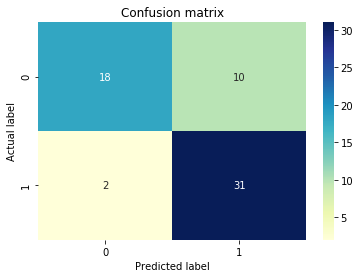

In [16]:
conf_matrix(skllog, X_test, Y_test)

*Самодельная:*

In [17]:
param_grid = {'C':np.arange(0.1, 3, 0.04),
              'l2_reg': [True], 
              'speed': np.arange(0.3, 1, 0.3)}
log_cv= OwnGridSearchCV(OwnLogisticRegression, param_grid, cv=5)
log_cv.fit(X_train, Y_train)

print("Best Score:" + str(log_cv.best_score_))
print("Best Parameters: " + str(log_cv.best_params_))
ownlog = OwnLogisticRegression(**log_cv.best_params_)
ownlog.fit(X_train, Y_train)

100%|█████████▉| 218/219 [05:48<00:01,  1.60s/it]


Best Score:0.8343537414965987
Best Parameters: {'C': 2.2600000000000007, 'l2_reg': True, 'speed': 0.6}


In [18]:
metric_report(ownlog, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61



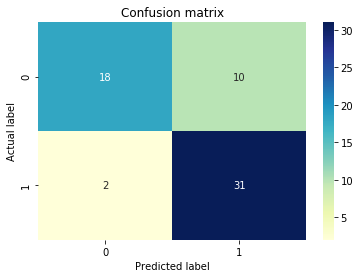

In [19]:
conf_matrix(ownlog, X_test, Y_test)

#### Решающее дерево

In [20]:
from sklearn.tree import DecisionTreeClassifier

Реализация алгоритма:

In [28]:
class OwnDecisionTree:
    def __init__(self, min_size=2):
        self.min_size = min_size

    def fit(self,X,y):
        dataset = np.column_stack([X,y])
        self.tree = self.build_tree(dataset)

    def predict(self,X):
        if len(X.shape) == 1:
            return  self.predict_one(self.tree,X)
        else:
            y_pred = []
            for x in X:
                y_pred.append(self.predict_one(self.tree,x))
            return y_pred

    def gini_index(self,groups,classes):
        n_instanse = float(sum([ len(group) for group in groups ]))
        gini = 0.0
        for group in groups:
            size = float(len(group))
            if size == 0:
                continue
            score = 0.0
            for class_val in classes:
                p = [row[-1] for row in group].count(class_val)/size
                score +=p*p
            gini +=(1.0 - score)*(size/n_instanse)
        return  gini

    def test_split(self,index, value, dataset):
        left, rigth = [],[]
        for row in dataset:
            if row[index]<value:
                left.append(row)
            else:
                rigth.append(row)
        return left, rigth

    def get_split(self,dataset):
        class_values = list(set(row[-1] for row in dataset))
        b_index, b_value, b_score, b_groups = 999, 999, 999, None

        for index in range(len(dataset[0]) - 1):
            for row in dataset:
                groups = self.test_split(index,row[index],dataset)
                gini = self.gini_index(groups,class_values)
                if gini < b_score:
                    b_index, b_value, b_score, b_groups = index, row[index], gini, groups
        return  {'index':b_index,'value':b_value,'groups':b_groups}

    def to_terminal(self,group):
        outcomes = [row[-1] for row in group]
        return  max(set(outcomes), key=outcomes.count)

    def split(self,node,depth):
        min_size = self.min_size

        left, right = node['groups']
        del(node['groups'])
        if not left or not  right:
            node['left'] = node['right'] = self.to_terminal(left+right)
            return

        if len(left) <= min_size:
            node['left'] =self.to_terminal(left)
        else:
            node['left'] = self.get_split(left)
            self.split(node['left'], depth + 1)

        if len(right) <= min_size:
            node['right'] = self.to_terminal(right)
        else:
            node['right'] = self.get_split(right)
            self.split(node['right'], depth + 1)

    def build_tree(self,train):
        root = self.get_split(train)
        self.split(root,1)
        return  root


    def predict_one(self,node,row):
        if row[node['index']] < node['value']:
            if isinstance(node['left'], dict):
                return self.predict_one(node['left'], row)
            else:
                return node['left']
        else:
            if isinstance(node['right'], dict):
                return self.predict_one(node['right'], row)
            else:
                return node['right']
            
    def score(self, X_val, Y_val, metric=accuracy):
        return metric(Y_val, self.predict(X_val))

*sklearn:*

In [22]:
# настройка параметра стрижки
param_grid = {'ccp_alpha':np.arange(0.001, 0.1, 0.002)}
tree_cv= GridSearchCV(DecisionTreeClassifier(),param_grid,cv=5)
tree_cv.fit(X_train, Y_train)

print("Best Score:" + str(tree_cv.best_score_))
print("Best Parameters: " + str(tree_cv.best_params_))
skltree = DecisionTreeClassifier(**tree_cv.best_params_)
skltree.fit(X_train, Y_train)

Best Score:0.7897108843537415
Best Parameters: {'ccp_alpha': 0.023}


DecisionTreeClassifier(ccp_alpha=0.023, class_weight=None, criterion='gini',
                       max_depth=None, max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort='deprecated',
                       random_state=None, splitter='best')

In [23]:
# здесь нечего настраивать
metric_report(skltree, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.76      0.46      0.58        28
           1       0.66      0.88      0.75        33

    accuracy                           0.69        61
   macro avg       0.71      0.67      0.67        61
weighted avg       0.71      0.69      0.67        61



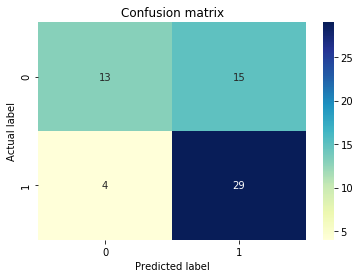

In [24]:
conf_matrix(skltree, X_test, Y_test)

*Самодельная:*

In [29]:
owntree = OwnDecisionTree()

owntree.fit(X_train, Y_train)

In [30]:
metric_report(owntree, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.73      0.68      0.70        28
           1       0.74      0.79      0.76        33

    accuracy                           0.74        61
   macro avg       0.74      0.73      0.73        61
weighted avg       0.74      0.74      0.74        61



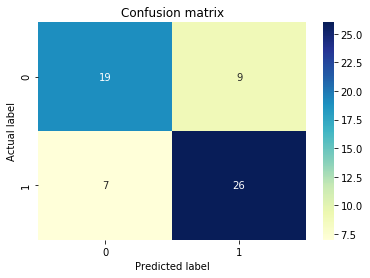

In [31]:
conf_matrix(owntree, X_test, Y_test)

#### K ближайших соседей

In [32]:
from sklearn.neighbors import KNeighborsClassifier

Реализация алгоритма:

In [33]:
def minkovski(x1, x2, p = 3):
    return (np.abs(x1 - x2) ** p).T.sum(axis = 0)**(1.0 / p)

def euclid(x1, x2):
    return minkovski(x1, x2, 2)

# обычный KNN
class OwnKNN:
    def __init__(self, k = 5, metric = euclid):
        self.k = k
        self.p = metric
        self.X = None
        self.Y = None
    
    def fit(self, X_train, Y_train):
        self.X = X_train
        self.Y = Y_train
        self.k = min(self.k, len(self.Y) - 1)
        return self

    def predict(self, X_val):
        Y_pred = np.zeros(len(X_val)).astype(np.int8)
        for i in np.arange(len(X_val)):
            Y_pred[i] = self.predict_one(X_val[i])
        return Y_pred
    
    # сортим и берем первые k
    def predict_one(self, x):
        r_x = self.p(self.X, x)
        order = np.argsort(r_x)
        h = r_x[order[self.k]]
        order = order[:self.k]
        Y_k = self.Y[order]
        pos_w = Y_k.sum()
        neg_w = np.logical_not(Y_k).sum()
        return int(pos_w > neg_w) 


    def score(self, X_val, Y_val, metric=accuracy):
        return metric(Y_val, self.predict(X_val))

*sklearn:*

In [34]:
param_grid = {'n_neighbors':np.arange(1,65)}
knn_cv= GridSearchCV(KNeighborsClassifier(),param_grid,cv=5)
knn_cv.fit(X_train, Y_train)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))
sklknn = KNeighborsClassifier(**knn_cv.best_params_)
sklknn.fit(X_train, Y_train)

Best Score:0.8185374149659864
Best Parameters: {'n_neighbors': 5}


KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=5, p=2,
                     weights='uniform')

In [35]:
metric_report(sklknn, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.74      0.82      0.78        28
           1       0.83      0.76      0.79        33

    accuracy                           0.79        61
   macro avg       0.79      0.79      0.79        61
weighted avg       0.79      0.79      0.79        61



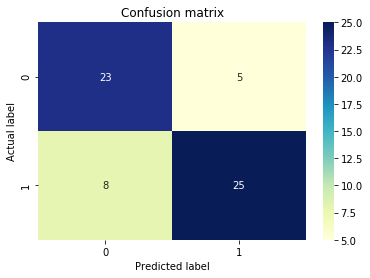

In [36]:
conf_matrix(sklknn, X_test, Y_test)

*Самодельная:*

In [38]:
param_grid = {'k':np.arange(1,65)}
knn_cv= OwnGridSearchCV(OwnKNN, param_grid, cv=5)
knn_cv.fit(X_train, Y_train)

print("Best Score:" + str(knn_cv.best_score_))
print("Best Parameters: " + str(knn_cv.best_params_))
ownknn = OwnKNN(**knn_cv.best_params_)
ownknn.fit(X_train, Y_train)

 98%|█████████▊| 63/64 [00:03<00:00, 16.13it/s]

Best Score:0.8138605442176872
Best Parameters: {'k': 1}


In [39]:
metric_report(ownknn, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.78      0.75      0.76        28
           1       0.79      0.82      0.81        33

    accuracy                           0.79        61
   macro avg       0.79      0.78      0.78        61
weighted avg       0.79      0.79      0.79        61



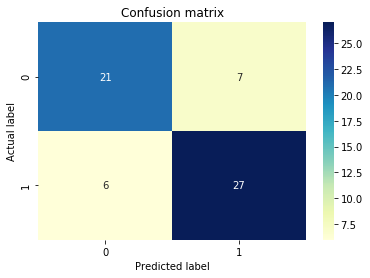

In [40]:
conf_matrix(ownknn, X_test, Y_test)

#### Метод опорных векторов

In [41]:
from sklearn.svm import LinearSVC

Реализация алгоритма:

In [42]:
# метод опорнных векторов для бинарной классификации
class OwnSVM:
    def __init__(self, speed=0.001, l2_reg = False, C=0.5, maxsteps=2500):
        self.maxsteps = maxsteps
        self.speed = speed
        if l2_reg:
            self.l2 = lambda w: w / C
        else:
            self.l2 = lambda w: 0.0   
        self.C = C

    def fit(self,X,y):
        self.X = np.column_stack((np.ones(len(X)), X))
        self.y = np.array(y)
        self.y[y == 0] = -1

        self.w = np.ones(len(self.X[0]))
        self.gradient_descent_search()
    
    # обучим градиентным спуском
    def gradient_descent_search(self):
        for i in range(self.maxsteps):
            L, dw = self.get_cost_grads(self.X, self.w, self.y)
            self.w = self.w - self.speed * dw
        return self.w
            
    def distances(self, w, with_lagrange=True):
        distances = self.y * (np.dot(self.X, w)) - 1
        if with_lagrange:
            distances[distances > 0] = 0
        return distances
    
    # градиент функции потерь L = max(0, 1 - M)
    def get_cost_grads(self, X, w, y):
        distances = self.distances(w)
        # Функция потерь
        L = 1 / 2 * np.dot(w, w) - (1 / self.C) * np.sum(distances)
        ds = -np.sign(distances)
        p = np.dot(X.T,ds*y)
        # градиент с регуляризацией
        dw = w - self.l2(p)
        return L, dw / len(X)

    def predict(self, X):
        X = np.column_stack((np.ones(len(X)), X))
        y = np.sign(X @ self.w)
        y[y==-1] = 0
        return y
    
    def score(self, X_val, Y_val, metric=accuracy):
        return metric(Y_val, self.predict(X_val))

*slkearn:*

In [43]:
param_grid = {'C':np.arange(0.1, 3, 0.04)}
svm_cv = GridSearchCV(LinearSVC(),param_grid,cv=5)
svm_cv.fit(X_train, Y_train)

print("Best Score:" + str(svm_cv.best_score_))
print("Best Parameters: " + str(svm_cv.best_params_))
sklsvm = LinearSVC(**svm_cv.best_params_)
sklsvm.fit(X_train, Y_train)

Best Score:0.8473639455782314
Best Parameters: {'C': 0.3400000000000001}


LinearSVC(C=0.3400000000000001, class_weight=None, dual=True,
          fit_intercept=True, intercept_scaling=1, loss='squared_hinge',
          max_iter=1000, multi_class='ovr', penalty='l2', random_state=None,
          tol=0.0001, verbose=0)

In [44]:
metric_report(sklsvm, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.90      0.64      0.75        28
           1       0.76      0.94      0.84        33

    accuracy                           0.80        61
   macro avg       0.83      0.79      0.79        61
weighted avg       0.82      0.80      0.80        61



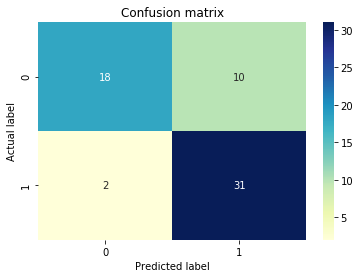

In [45]:
conf_matrix(sklsvm, X_test, Y_test)

*Самодельная:*

In [46]:
param_grid = {'C':np.arange(0.1, 3, 0.04),
              'l2_reg': [True], 
              'speed': np.arange(0.3, 1, 0.3)}
svm_cv= OwnGridSearchCV(OwnSVM, param_grid, cv=5)
svm_cv.fit(X_train, Y_train)

print("Best Score:" + str(svm_cv.best_score_))
print("Best Parameters: " + str(svm_cv.best_params_))
ownsvm = OwnSVM(**svm_cv.best_params_)
ownsvm.fit(X_train, Y_train)

100%|█████████▉| 218/219 [09:34<00:02,  2.63s/it]


Best Score:0.8509353741496598
Best Parameters: {'C': 0.38, 'l2_reg': True, 'speed': 0.6}


In [47]:
metric_report(ownsvm, X_test, Y_test)

              precision    recall  f1-score   support

           0       0.78      0.64      0.71        28
           1       0.74      0.85      0.79        33

    accuracy                           0.75        61
   macro avg       0.76      0.75      0.75        61
weighted avg       0.76      0.75      0.75        61



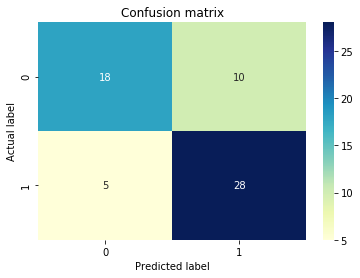

In [48]:
conf_matrix(ownsvm, X_test, Y_test)

#### Результат

*Наилучший результат:* Логистическая регрессия как в моей, так и сторонней реализации, а также *sklearn* метод опорных векторов.

In [49]:
print("Точность модели:", ownlog.score(X_test, Y_test))

Точность модели: 0.8032786885245902


*Наихудший результат:* sklearn реализация решающего дерева. Мое дерево показало себя не сильно лучше в силу склонности деревьев к переобучению.

In [50]:
print("Точность модели:", skltree.score(X_test, Y_test))

Точность модели: 0.6885245901639344


Исходя из значений метрик я пришла к выводу, что модели, написанные мной в целом не уступают моделям *sklearn* по качеству классификации, не считая реализации метода опорных векторов, которая получилась неудачной. Оценить скорость моделей я не смогла, поскольку размер данных маленький и все модели работали сравнительно быстро.